In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# 데이터 불러오기 및 전처리 과정(모든 모델에 동일부분임)

In [2]:
data = pd.read_csv('data_file_csv.csv', encoding='cp949')

In [3]:
#딕셔너리에 키 값을 대입해 벨류값을 얻어오는 함수
def get_value(k,dic):
    for key, value in dic.items():
         if k == key:
            return value
        
#string, float등 의사결정나무에서는 사용하기 힘든 변수를 사용할 수 있게끔 만들어주는 함수
def get_index(name):
    temp_list = data[name].tolist()
    temp_set = set(temp_list)
    temp_list2 = list(temp_set)
    dic= {string:i for i,string in enumerate(temp_list2)}
    
    for i in range(len(temp_list)):
        temp = data.loc[i,name]
        temp_value = get_value(temp,dic)
        data.loc[i,name] = temp_value
        
#여기서부터 srartpos1에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('startpos1')
    
#여기서부터 startpos2에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('startpos2')
    
#여기서부터 endpos2에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('endpos2')
data.drop(columns=["Unnamed: 0"],inplace=True)
data['startpos1'] = pd.to_numeric(data['startpos1'])
data['startpos2'] = pd.to_numeric(data['startpos2'])
# list로 만들기
list_whycall=data['whycall'].to_list()
list_gotoschool=data['gotoschool'].to_list()
list_gotocharge=data['gotocharge'].to_list()
# end_destination에 연산결과 추가하기
data['end_destination'] = 0
for i in range(len(list_whycall)):
    if (list_whycall[i] *100+ 
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 100) :
        data.iloc[i, 21] = 3
    elif (list_whycall[i] *100+ 
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 10) :
        data.iloc[i, 21] = 2
    elif (list_whycall[i] *100+ 
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 10) :
        data.iloc[i, 21] = 1
    else :
        data.iloc[i, 21] = 0
#변수 endlat과 endlon을 합치는 작업
te_list = data['startlat'].tolist()
for i in range (len(te_list)):
    data.loc[i,'startplus'] = ['1']

for i in range (len(te_list)):
    a = data.loc[i,'startlat']
    b = data.loc[i,'startlon']
    
    a = a * 10
    b = b * 10
    a = a % 100
    b = b % 100
    a = int(a)
    b = int(b)
    new = a*100 + b
    data.loc[i,'startplus'] = [new]
data.head()

,no,cartype,receipttime,settime,ridetime,startpos1,startpos2,endpos1,endpos2,receipt,...,startlat,startlon,endlat,endlon,whycall,gotoschool,gotocharge,endplus,end_destination,startplus
0,8075,중형 승합,2022-05-07 오전 12:08:21,2022-05-07 오전 12:15:19,2022-05-07 오전 12:30:26,24,87,동작구,248,2022/05/07 0:08,...,37.53,126.90,37.49,126.90,0,0,0,7469,0,7569
1,8231,중형승합,2022-05-07 오전 12:08:51,2022-05-07 오전 12:17:25,2022-05-07 오전 12:46:23,12,3,관악구,229,2022/05/07 0:08,...,37.50,126.88,37.47,126.97,0,0,0,7469,0,7568
2,8279,중형 승합,2022-05-07 오전 12:09:00,2022-05-07 오전 12:26:57,2022-05-07 오전 12:54:43,6,230,노원구,156,2022/05/07 0:09,...,37.67,127.08,37.64,127.07,0,0,0,7670,0,7670
3,1560,중형 승합,2022-05-07 오전 12:13:00,2022-05-07 오전 12:14:01,2022-05-07 오전 12:14:25,19,152,강동구,38,2022/05/07 0:13,...,37.59,127.08,37.54,127.13,0,0,0,7571,0,7570
4,7913,중형승합,2022-05-07 오전 12:18:00,2022-05-07 오전 1:15:54,2022-05-07 오전 1:33:16,19,54,동대문구,62,2022/05/07 0:18,...,37.61,127.09,37.57,127.06,0,0,0,7570,0,7670


In [4]:
lr_data = LogisticRegression(solver="liblinear", C = 100, penalty = 'l1')
knn_data = KNeighborsClassifier(
    n_neighbors=11,
    metric = 'manhattan',
    weights = 'distance'
)
#  개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_data = VotingClassifier(estimators=[("LR", lr_data), 
                                       ("KNN", knn_data)], voting="soft")

In [5]:
x=np.array(data.loc[: ,['end_destination', 'startplus',
                        'receipt-ride','hour',
                         'startpos1', 'startpos2']])
y=data['endplus']
#  data train,test로 나누기
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.1, 
                                                    random_state=42, shuffle=False)
scaler = StandardScaler()
x_train_Scaled = scaler.fit_transform(x_train)
x_test_Scaled = scaler.fit_transform(x_test)
# 정확도 
classifiers = [lr_data, knn_data, vo_data]
for classifier in classifiers:
    classifier.fit(x_train_Scaled, y_train)
    pred = classifier.predict(x_test_Scaled)
    name = classifier.__class__.__name__
    print(f"{name} 정확도 : {accuracy_score(y_test, pred)}")

LogisticRegression 정확도 : 0.375
KNeighborsClassifier 정확도 : 0.5625
VotingClassifier 정확도 : 0.5480769230769231


C:\Users\chosungsu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\chosungsu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
#평가지표만들기
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

# 모델 성능 확인을 위한 함수
#prediction plot(예측 )
def plot_predictions(name_, actual, pred):
#     데이터 프레임을 만든다.
    df = pd.DataFrame({'actual': y_test, 'prediction': pred})
#     index reset하기
    df = df.sort_values(by='actual').reset_index(drop=True)
# 시각화
    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

# evaluation plot(평가)
def mse_eval(name_, actual, pred):
    global predictions
    global colors

    plot_predictions(name_, actual, pred)

#  MSE (평균 제곱 오차)
    mse = mean_squared_error(actual, pred)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
#     데이터프레임 만들기
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
#     시각화
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

# remove model
def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True


# coefficients visulization
def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

0.29863588205827307


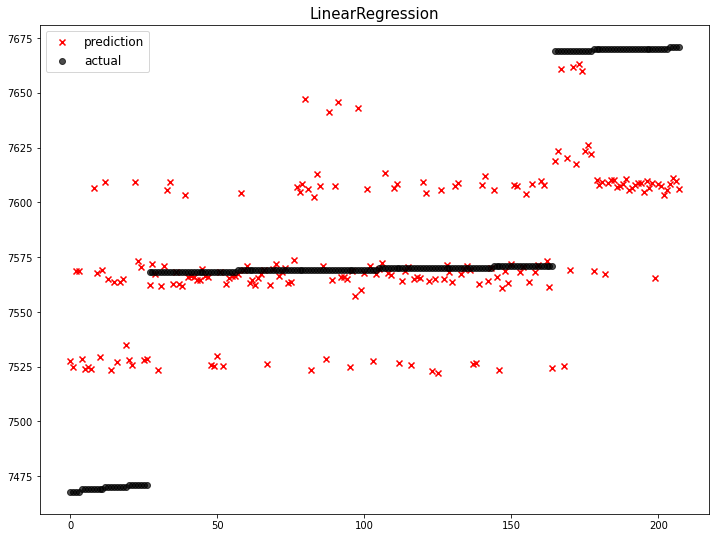

              model          mse
0  LinearRegression  2324.926583


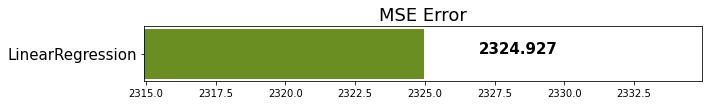

In [7]:
# Linear Regression모델
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(x_train, y_train)
print(linear_reg.score(x_test, y_test))
linear_pred = linear_reg.predict(x_test)
mse_eval('LinearRegression', y_test, linear_pred)

0.29862091621935083


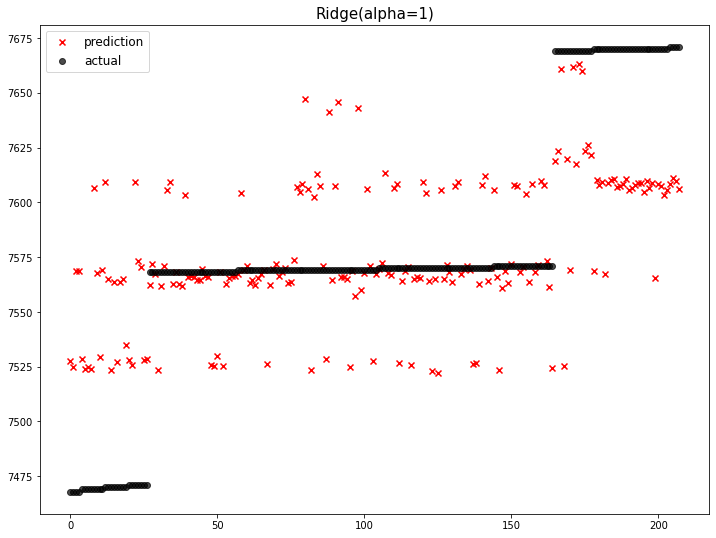

              model          mse
0    Ridge(alpha=1)  2324.976193
1  LinearRegression  2324.926583


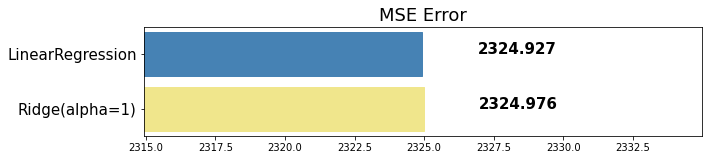

In [8]:
# Ridge 모델
ridge = Ridge(alpha=1)
ridge.fit(x_train, y_train)
print(ridge.score(x_test, y_test))
ridge_pred = ridge.predict(x_test)
mse_eval('Ridge(alpha=1)', y_test, ridge_pred)

0.2986295256326573


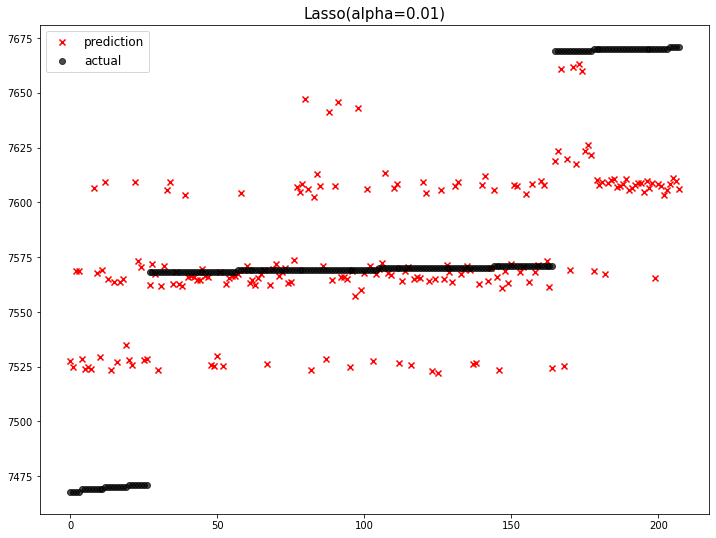

               model          mse
0     Ridge(alpha=1)  2324.976193
1  Lasso(alpha=0.01)  2324.947654
2   LinearRegression  2324.926583


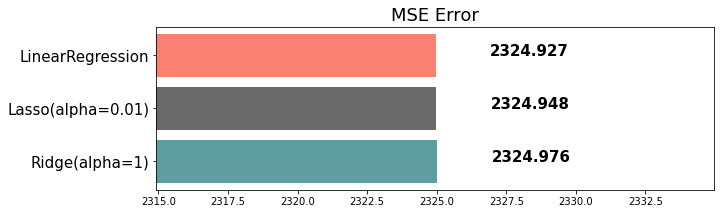

In [9]:
# LASSO모델
lasso = Lasso(alpha=0.01)
lasso.fit(x_train, y_train)
print(lasso.score(x_test, y_test))
lasso_pred = lasso.predict(x_test)
mse_eval('Lasso(alpha=0.01)', y_test, lasso_pred)

0.2771582766939974


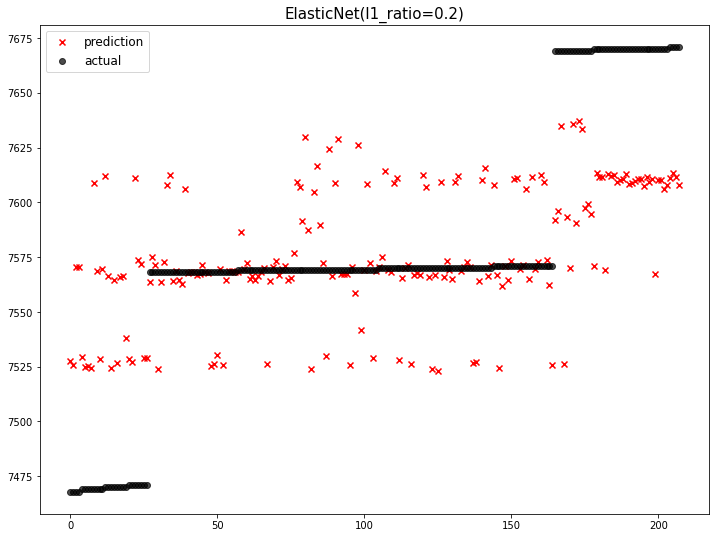

                      model          mse
0  ElasticNet(l1_ratio=0.2)  2396.121921
1            Ridge(alpha=1)  2324.976193
2         Lasso(alpha=0.01)  2324.947654
3          LinearRegression  2324.926583


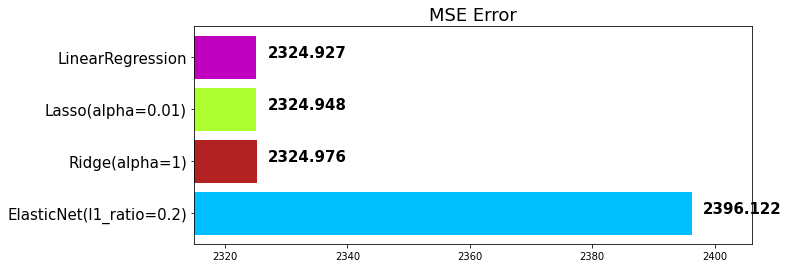

In [10]:
# ElasticNet모델
elasticnet = ElasticNet(alpha=0.5, l1_ratio=0.2)
elasticnet.fit(x_train, y_train)
print(elasticnet.score(x_test, y_test))
elas_pred = elasticnet.predict(x_test)
mse_eval('ElasticNet(l1_ratio=0.2)', y_test, elas_pred)

0.2810594951284998


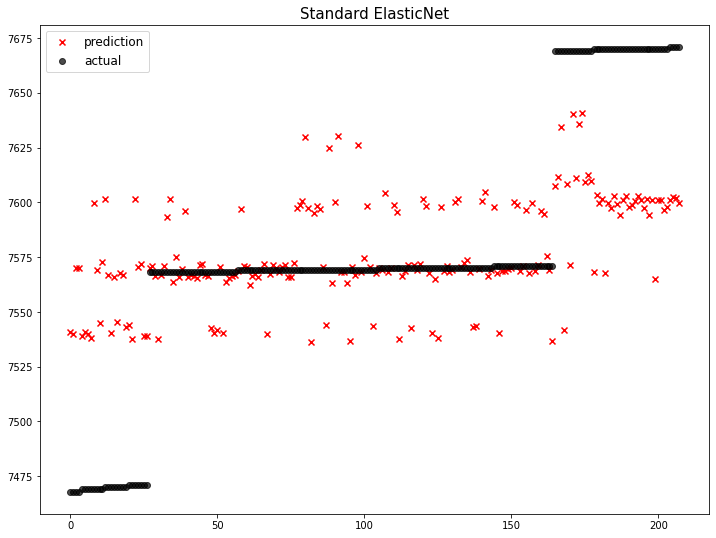

                      model          mse
0  ElasticNet(l1_ratio=0.2)  2396.121921
1       Standard ElasticNet  2383.189913
2            Ridge(alpha=1)  2324.976193
3         Lasso(alpha=0.01)  2324.947654
4          LinearRegression  2324.926583


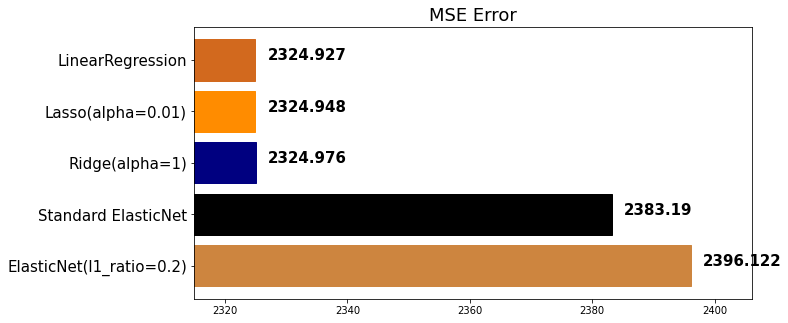

In [11]:
# With Standard Scaling 모델
standard_elasticnet = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.5, l1_ratio=0.2)
)

standard_elasticnet = standard_elasticnet.fit(x_train, y_train)
print(standard_elasticnet.score(x_test, y_test))
elas_scaled_pred = standard_elasticnet.predict(x_test)
mse_eval('Standard ElasticNet', y_test, elas_scaled_pred)

0.3089063616137572


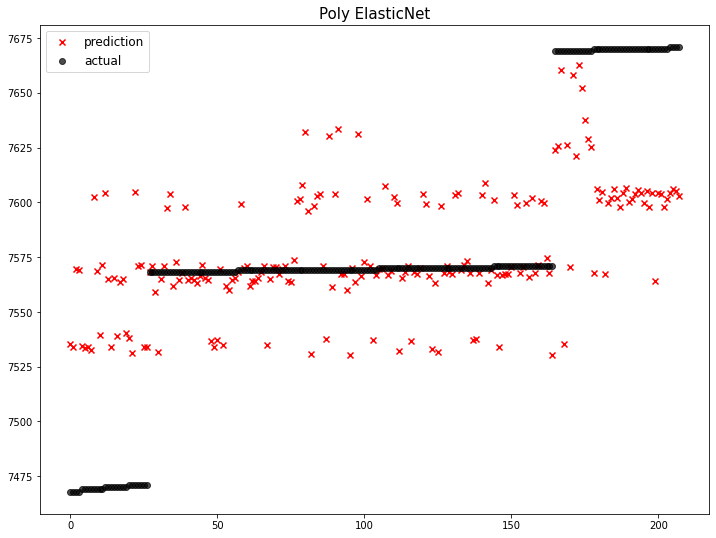

                      model          mse
0  ElasticNet(l1_ratio=0.2)  2396.121921
1       Standard ElasticNet  2383.189913
2            Ridge(alpha=1)  2324.976193
3         Lasso(alpha=0.01)  2324.947654
4          LinearRegression  2324.926583
5           Poly ElasticNet  2290.881341


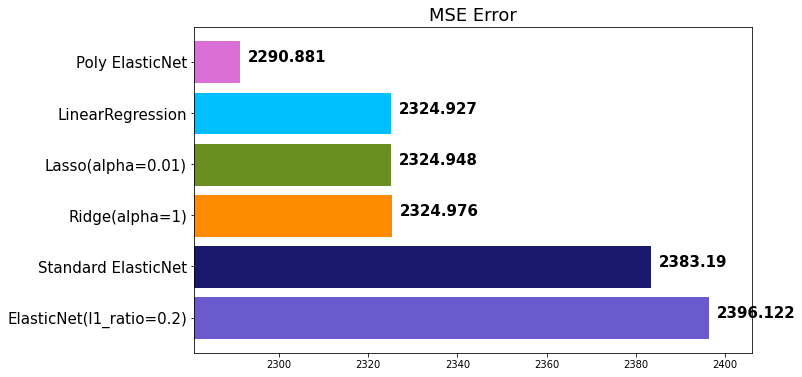

In [12]:
# Polynomial Features 모델
poly_elasticnet = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    ElasticNet(alpha=0.5, l1_ratio=0.2)
)

poly_elasticnet = poly_elasticnet.fit(x_train, y_train)
print(poly_elasticnet.score(x_test, y_test))
poly_pred = poly_elasticnet.predict(x_test)
mse_eval('Poly ElasticNet', y_test, poly_pred)

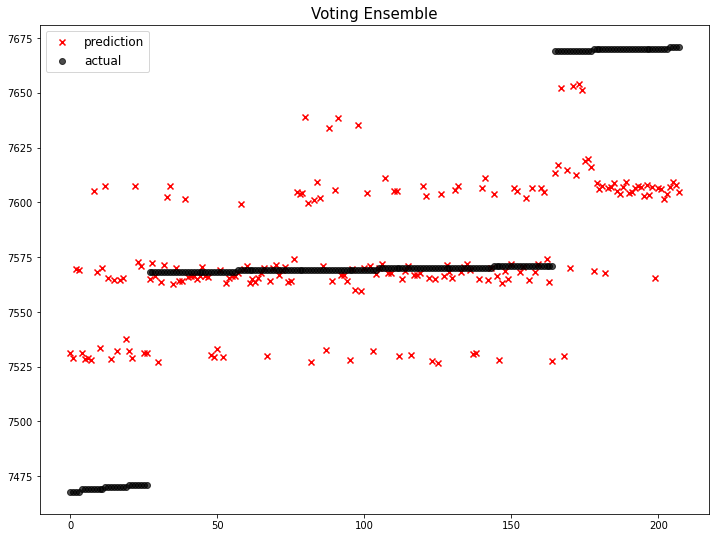

                      model          mse
0  ElasticNet(l1_ratio=0.2)  2396.121921
1       Standard ElasticNet  2383.189913
2            Ridge(alpha=1)  2324.976193
3         Lasso(alpha=0.01)  2324.947654
4          LinearRegression  2324.926583
5           Voting Ensemble  2321.626392
6           Poly ElasticNet  2290.881341


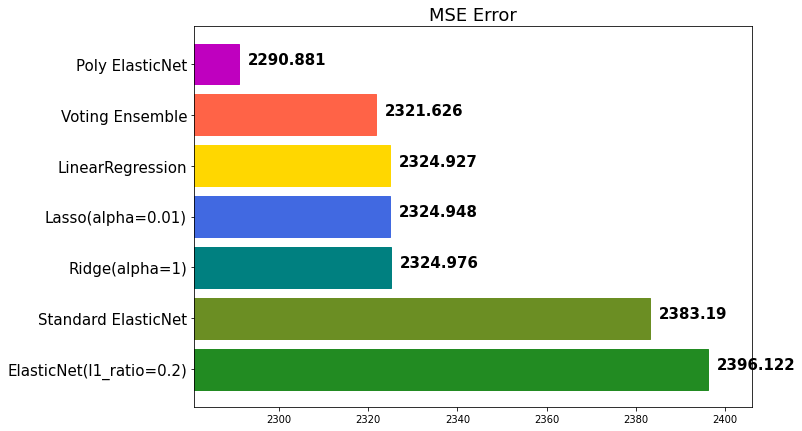

In [13]:
from sklearn.ensemble import VotingRegressor

# 보팅에 참여한 single models 지정
single_models = [
    ('linear_reg', linear_reg),
    ('ridge', ridge),
    ('lasso', lasso),
    ('elasticnet', elasticnet),
    ('standard_elasticnet', standard_elasticnet),
    ('poly_elasticnet', poly_elasticnet)
]

# voting regressor 만들기
voting_regressor = VotingRegressor(single_models, n_jobs=-1)


voting_regressor.fit(x_train, y_train)
VotingRegressor(estimators=[('linear_reg',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=-1, normalize=False)),
                            ('ridge',
                             Ridge(alpha=1, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001)),
                            ('lasso',
                             Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=False)),
                                             ('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('elasticnet',
                                              ElasticNet(alpha=0.5, copy_X=True,
                                                         fit_intercept=True,
                                                         l1_ratio=0.2,
                                                         max_iter=1000,
                                                         normalize=False,
                                                         positive=False,
                                                         precompute=False,
                                                         random_state=None,
                                                         selection='cyclic',
                                                         tol=0.0001,
                                                         warm_start=False))], n_jobs=-1, weights=None)


voting_pred = voting_regressor.predict(x_test)
mse_eval('Voting Ensemble', y_test, voting_pred)